In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("iot_network_analysis_dataset_10000.csv")
df = df.dropna()
df['DDoS_Label'] = LabelEncoder().fit_transform(df['DDoS_Label'])

X = df.select_dtypes(include='number').drop(columns=['DDoS_Label']).values
y = df['DDoS_Label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [3]:
def bat_optimize(iterations=10, pop_size=10, min_neurons=8, max_neurons=128):
    def evaluate(n_neurons):
        n_neurons = int(round(n_neurons))
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1, X_train.shape[2])),
            tf.keras.layers.SimpleRNN(n_neurons, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)
        _, acc = model.evaluate(X_test, y_test, verbose=0)
        return acc

    bats = np.random.randint(min_neurons, max_neurons + 1, size=(pop_size,))
    velocities = np.zeros(pop_size)
    fitness = np.zeros(pop_size)

    for i in range(pop_size):
        fitness[i] = evaluate(bats[i])

    best = bats[np.argmax(fitness)]

    for t in range(iterations):
        for i in range(pop_size):
            beta = np.random.rand()
            velocities[i] += (bats[i] - best) * beta
            bats[i] = np.clip(bats[i] + int(round(velocities[i])), min_neurons, max_neurons)
            fnew = evaluate(bats[i])
            if fnew > fitness[i]:
                fitness[i] = fnew
                if fnew > evaluate(best):
                    best = bats[i]

    return int(best)


In [4]:
optimal_neurons = bat_optimize(iterations=5, pop_size=6, min_neurons=8, max_neurons=128)
print(f" Optimal Neurons from RB: {optimal_neurons}")

 Optimal Neurons from RB: 106


In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(optimal_neurons, activation='relu', input_shape=(1, X_train.shape[2])),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print(" Accuracy:", accuracy_score(y_test, y_pred))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6552 - loss: 0.6329
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7046 - loss: 0.5849
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7015 - loss: 0.5774
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7069 - loss: 0.5719
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7220 - loss: 0.5506
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7376 - loss: 0.5423
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7356 - loss: 0.5344
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7610 - loss: 0.5189
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7604 - loss: 0.5170
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7695 - loss: 0.5066
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.

In [6]:
def game_theory_security(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Assign weights: success +10, failure -20, false alarm -5
    attacker_score = (fn * 15) - (tp * 10)
    defender_score = (tp * 10) - (fn * 20) - (fp * 5)

    print(f" Confusion Matrix → TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")
    return attacker_score, defender_score
attacker_score, defender_score = game_theory_security(y_test, y_pred)
print(f"Attacker Score: {attacker_score}, Defender Score: {defender_score}")

 Confusion Matrix → TP: 1374, FN: 39, FP: 422, TN: 165
Attacker Score: -13155, Defender Score: 10850


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Threshold Tuning Results:

Threshold = 0.3
TP: 2800566, FN: 25434, FP: 1163434, TN: 10566
Attacker Score: -2368490,  Defender Score: 21679810



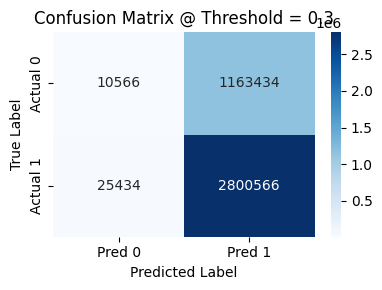

Threshold = 0.4
TP: 2724264, FN: 101736, FP: 1131736, TN: 42264
Attacker Score: -2303960,  Defender Score: 19549240



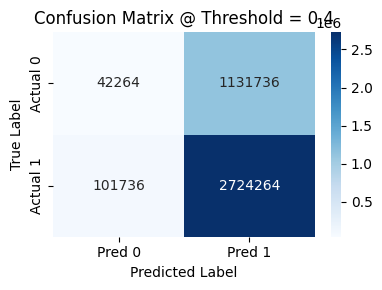

Threshold = 0.5
TP: 2537748, FN: 288252, FP: 1054252, TN: 119748
Attacker Score: -2146220,  Defender Score: 14341180



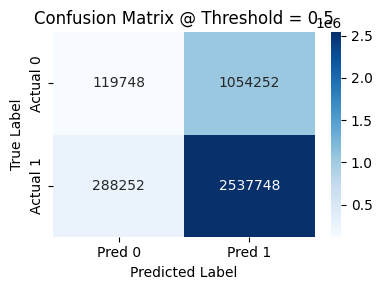

Threshold = 0.6
TP: 2242431, FN: 583569, FP: 931569, TN: 242431
Attacker Score: -1896465,  Defender Score: 6095085



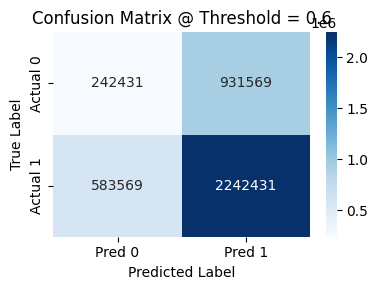

Threshold = 0.7
TP: 1725273, FN: 1100727, FP: 716727, TN: 457273
Attacker Score: -1459095,  Defender Score: -8345445



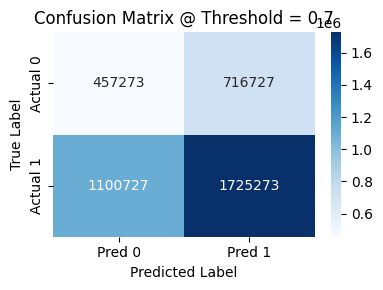

Threshold = 0.8
TP: 979209, FN: 1846791, FP: 406791, TN: 767209
Attacker Score: -828135,  Defender Score: -29177685



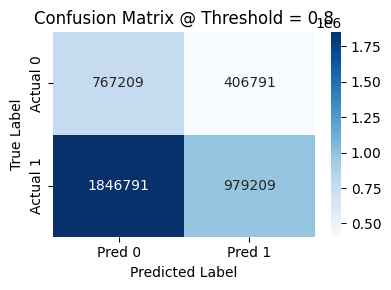

Threshold = 0.9
TP: 240210, FN: 2585790, FP: 99790, TN: 1074210
Attacker Score: -203150,  Defender Score: -49812650



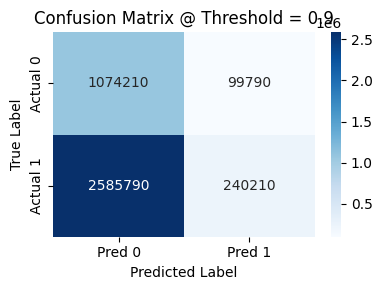

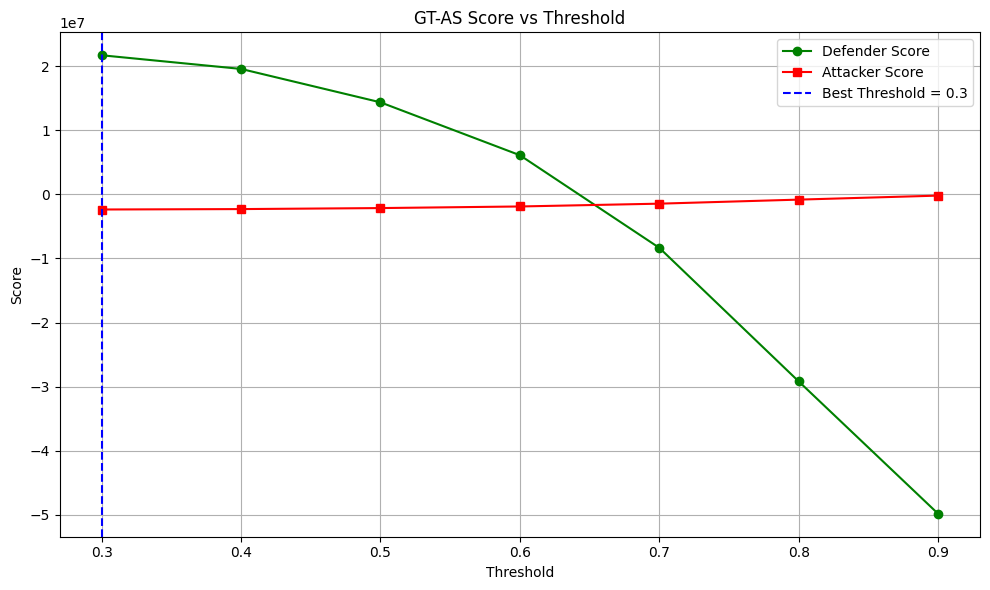


Best Threshold: 0.3 with Defender Score = 21679810


In [7]:

y_pred_prob = model.predict(X_test)

def evaluate_thresholds(y_true, y_pred_prob):
    thresholds = np.arange(0.3, 1.0, 0.1)
    defender_scores = []
    attacker_scores = []

    best_threshold = 0
    best_defender_score = float('-inf')

    print("Threshold Tuning Results:\n")

    for threshold in thresholds:
        threshold = round(threshold, 2)
        y_pred = (y_pred_prob > threshold).astype(int)

        TP = np.sum((y_true == 1) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))

        cm = np.array([[TN, FP],
                       [FN, TP]])

        attacker_score = (FP * 10) - (TP * 5)
        defender_score = (TP * 10) - (FN * 20) - (FP * 5)

        print(f"Threshold = {threshold}")
        print(f"TP: {TP}, FN: {FN}, FP: {FP}, TN: {TN}")
        print(f"Attacker Score: {attacker_score},  Defender Score: {defender_score}\n")

        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred 0', 'Pred 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix @ Threshold = {threshold}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()

        defender_scores.append(defender_score)
        attacker_scores.append(attacker_score)

        if defender_score > best_defender_score:
            best_threshold = threshold
            best_defender_score = defender_score

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, defender_scores, marker='o', label='Defender Score', color='green')
    plt.plot(thresholds, attacker_scores, marker='s', label='Attacker Score', color='red')
    plt.axvline(best_threshold, color='blue', linestyle='--', label=f'Best Threshold = {best_threshold}')
    plt.title("GT-AS Score vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nBest Threshold: {best_threshold} with Defender Score = {best_defender_score}")
    return best_threshold

best_thresh = evaluate_thresholds(y_test, y_pred_prob)


In [8]:
mitigation_threshold = 0.35

attack_predicted = (y_pred_prob >= mitigation_threshold).astype(int)
attack_indices = np.where(attack_predicted == 1)[0]

# Check if X_test is a DataFrame and has 'Source IP'
if isinstance(X_test, pd.DataFrame) and 'Source IP' in X_test.columns:
    blocked_ips = X_test.iloc[attack_indices]['Source IP'].values
else:
    # Dummy IP generation
    blocked_ips = [f"192.168.1.{i % 255}" for i in attack_indices]
blocked_ips_df = pd.DataFrame(blocked_ips, columns=['Blocked IPs'])
blocked_ips_df.to_csv("blocked_ips.csv", index=False)

print(f"\nTotal Blocked Connections: {len(blocked_ips)}")
print(f"Total Allowed Connections: {len(y_pred_prob) - len(blocked_ips)}")
print("Blocked IPs sample:")
print(blocked_ips_df.head())



Total Blocked Connections: 1969
Total Allowed Connections: 31
Blocked IPs sample:
   Blocked IPs
0  192.168.1.0
1  192.168.1.1
2  192.168.1.2
3  192.168.1.3
4  192.168.1.4


In [9]:
import time
import random

# Simulate real-time incoming network data
def generate_real_time_sample(scaler, feature_count):
    raw_sample = np.random.rand(feature_count).reshape(1, -1)
    scaled_sample = scaler.transform(raw_sample)
    return scaled_sample.reshape(1, 1, feature_count)

def real_time_detection(model, scaler, feature_count, threshold=mitigation_threshold, duration=10):
    start_time = time.time()
    blocked_ips = []

    print("\n--- Real-Time Detection Started ---")
    while time.time() - start_time < duration:
        # Simulate a network sample every 1 second
        time.sleep(1)
        sample = generate_real_time_sample(scaler, feature_count)
        prob = model.predict(sample)[0][0]

        ip = f"192.168.1.{random.randint(1, 254)}"  # Simulated source IP
        print(f"Incoming Sample from {ip} → Predicted Probability: {prob:.4f}")

        if prob >= threshold:
            print(f"!! Attack Detected from {ip} → Blocking IP.")
            blocked_ips.append(ip)
        else:
            print(f"✓ Connection from {ip} allowed.")

    print("\n--- Real-Time Detection Ended ---")
    print(f"Total Attacks Blocked: {len(blocked_ips)}")
    blocked_ips_df = pd.DataFrame(blocked_ips, columns=['Blocked IPs'])
    blocked_ips_df.to_csv("real_time_blocked_ips.csv", index=False)
    print("Blocked IPs: 'real_time_blocked_ips.csv'")
    print("Sample Blocked IPs:")
    print(blocked_ips_df.head())

real_time_detection(model, scaler, X_train.shape[2], threshold=mitigation_threshold, duration=15)



--- Real-Time Detection Started ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Incoming Sample from 192.168.1.111 → Predicted Probability: 0.9547
!! Attack Detected from 192.168.1.111 → Blocking IP.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Incoming Sample from 192.168.1.70 → Predicted Probability: 0.9642
!! Attack Detected from 192.168.1.70 → Blocking IP.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Incoming Sample from 192.168.1.26 → Predicted Probability: 0.9705
!! Attack Detected from 192.168.1.26 → Blocking IP.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Incoming Sample from 192.168.1.111 → Predicted Probability: 0.9746
!! Attack Detected from 192.168.1.111 → Blocking IP.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Incoming Sample from 192.168.1.19 → Predicted Probability: 0.9333
!! Attack Detected from 192.168.1.19 → Blocking IP.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Incoming Sample from 192.168.1.94 → Predicted Probability: 0.9838
!! Attack Detected from 192.168.1.94 → Blocking IP.
1/1 ━━━━━━━━━━━━━━━━━━━

In [11]:
import joblib
import os

joblib.dump(model, "ddos_model.pkl")
joblib.dump(scaler, "ddos_scaler.pkl")

['ddos_scaler.pkl']

In [16]:
import time
import random
import joblib
from scapy.all import sniff, IP, TCP, UDP
import pandas as pd
import numpy as np

# Load trained model and scaler
try:
    model = joblib.load("ddos_model.pkl")
    scaler = joblib.load("ddos_scaler.pkl")
    feature_count_for_scaler = scaler.n_features_in_
    expected_model_features = model.input_shape[-1]

except FileNotFoundError:
    print("Model or scaler files not found. Please run the training and saving steps first.")
    raise

flow_stats = []

def extract_packet_features(pkt):
    if IP in pkt:
        ip_layer = pkt[IP]
        protocol = 6 if TCP in pkt else (17 if UDP in pkt else 0)
        length = len(pkt)
        src_ip = ip_layer.src
        dst_ip = ip_layer.dst

        flow_stats.append({
            "src_ip": src_ip,
            "dst_ip": dst_ip,
            "Protocol": protocol,
            "PacketLength": length,
            "Timestamp": time.time()
        })

# Real-time classification
def process_and_predict():
    global flow_stats, model, scaler, feature_count_for_scaler, expected_model_features
    if not flow_stats:
        return

    df = pd.DataFrame(flow_stats)
    flow_stats = []
    flow_features = df.groupby(["src_ip", "dst_ip", "Protocol"]).agg({
        "PacketLength": ["count", "sum", "mean"],
        "Timestamp": ["min", "max"]
    }).reset_index()

    flow_features.columns = ['src_ip', 'dst_ip', 'Protocol', 'packet_count', 'total_bytes', 'avg_bytes', 'start_time', 'end_time']
    flow_features["flow_duration"] = flow_features["end_time"] - flow_features["start_time"]

    # Select features that are currently derivable from raw packets
    current_features = ["packet_count", "total_bytes", "avg_bytes", "flow_duration", "Protocol"]
    X = flow_features[current_features]
    X_np = X.values
    if X_np.shape[1] < feature_count_for_scaler:
        padded_X_np = np.zeros((X_np.shape[0], feature_count_for_scaler))
        padded_X_np[:, :X_np.shape[1]] = X_np
        X_np = padded_X_np
    elif X_np.shape[1] > feature_count_for_scaler:
        X_np = X_np[:, :feature_count_for_scaler]
    if X_np.shape[1] != feature_count_for_scaler:
         print(f"Error: Feature count ({X_np.shape[1]}) still does not match scaler's expected features ({feature_count_for_scaler}). Cannot scale.")
         return
    try:
        X_scaled = scaler.transform(X_np)
        if X_scaled.shape[1] != expected_model_features:
             print(f"Error: Scaled feature count ({X_scaled.shape[1]}) does not match model's expected input features ({expected_model_features}). Cannot predict.")
             return

        X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
        print(f"Shape after scaling and reshaping: {X_scaled.shape}")

    except Exception as e:
        print(f"Error during scaling or reshaping: {e}")
        print(f"Shape of X_np before scaling: {X_np.shape}")
        return

    #predictions
    if model is None:
        print("Model is not loaded or available. Cannot predict.")
        return

    try:
        predictions = model.predict(X_scaled)
        predictions_binary = (predictions > mitigation_threshold).astype(int)

    except Exception as e:
        print(f"Error during model prediction: {e}")
        return

    for i, pred_binary in enumerate(predictions_binary):
        src = flow_features.iloc[i]['src_ip']
        dst = flow_features.iloc[i]['dst_ip']
        label = "DDoS Attack" if pred_binary == 1 else "Normal"
        print(f"[{time.strftime('%H:%M:%S')}] {src} ➝ {dst} => {label}")

# Live Sniffing
if 'mitigation_threshold' not in globals():
     mitigation_threshold = 0.35

print("Starting real-time DDoS detection...")
sniff(prn=extract_packet_features, store=False, timeout=10)
process_and_predict()
print("Cycle complete. Run again to keep detecting...")

Starting real-time DDoS detection...
Shape after scaling and reshaping: (2, 1, 15)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
[05:14:22] 172.28.0.1 ➝ 172.28.0.12 => DDoS Attack
[05:14:22] 172.28.0.12 ➝ 172.28.0.1 => DDoS Attack
Cycle complete. Run again to keep detecting...


In [16]:
import time
import joblib
from scapy.all import sniff, IP, TCP, UDP
import pandas as pd
import numpy as np
import os

# Load model and scaler
try:
    model = joblib.load("ddos_model.pkl")
    scaler = joblib.load("ddos_scaler.pkl")
    feature_count_for_scaler = scaler.n_features_in_
    expected_model_features = model.input_shape[-1]
except FileNotFoundError:
    print("Model or scaler files not found. Please train and save them first.")
    raise

# Set detection threshold
mitigation_threshold = 0.35

flow_stats = []

# Extracting features from live packets
def extract_packet_features(pkt):
    if IP in pkt:
        ip_layer = pkt[IP]
        protocol = 6 if TCP in pkt else (17 if UDP in pkt else 0)
        length = len(pkt)
        src_ip = ip_layer.src
        dst_ip = ip_layer.dst

        flow_stats.append({
            "src_ip": src_ip,
            "dst_ip": dst_ip,
            "Protocol": protocol,
            "PacketLength": length,
            "Timestamp": time.time()
        })

# Process captured packets and doing predictions
def process_and_predict():
    global flow_stats, model, scaler, feature_count_for_scaler, expected_model_features

    if not flow_stats:
        print("No packets captured this cycle.")
        return

    df = pd.DataFrame(flow_stats)
    flow_stats = []

    flow_features = df.groupby(["src_ip", "dst_ip", "Protocol"]).agg({
        "PacketLength": ["count", "sum", "mean"],
        "Timestamp": ["min", "max"]
    }).reset_index()

    flow_features.columns = ['src_ip', 'dst_ip', 'Protocol', 'packet_count', 'total_bytes', 'avg_bytes', 'start_time', 'end_time']
    flow_features["flow_duration"] = flow_features["end_time"] - flow_features["start_time"]

    current_features = ["packet_count", "total_bytes", "avg_bytes", "flow_duration", "Protocol"]
    X = flow_features[current_features]
    X_np = X.values

    if X_np.shape[1] < feature_count_for_scaler:
        padded_X_np = np.zeros((X_np.shape[0], feature_count_for_scaler))
        padded_X_np[:, :X_np.shape[1]] = X_np
        X_np = padded_X_np
        print(f"Padded features from {X.shape[1]} to {X_np.shape[1]} for scaler compatibility.")

    elif X_np.shape[1] > feature_count_for_scaler:
        print(f"Truncating features from {X_np.shape[1]} to {feature_count_for_scaler}.")
        X_np = X_np[:, :feature_count_for_scaler]

    if X_np.shape[1] != feature_count_for_scaler:
        print(f"Feature count mismatch after padding/truncating. Skipping prediction.")
        return

    try:
        X_scaled = scaler.transform(X_np)
        if X_scaled.shape[1] != expected_model_features:
            print(f"Scaled feature mismatch with model input. Skipping prediction.")
            return
        X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
    except Exception as e:
        print(f"Error during scaling or reshaping: {e}")
        return

    try:
        predictions = model.predict(X_scaled)
        predictions_binary = (predictions > mitigation_threshold).astype(int)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # Log results to CSV
    log_file_path = "ddos_predictions_log.csv"
    flow_features["Prediction"] = predictions_binary
    save_header = not os.path.exists(log_file_path)
    flow_features.to_csv(log_file_path, mode='a', index=False, header=save_header)

    # Print detections
    for i, pred in enumerate(predictions_binary):
        src = flow_features.iloc[i]['src_ip']
        dst = flow_features.iloc[i]['dst_ip']
        label = "DDoS Attack" if pred == 1 else "Normal"
        print(f"[{time.strftime('%H:%M:%S')}] {src} ➝ {dst} => {label}")

    print("Flow Summary:")
    print(flow_features[["src_ip", "dst_ip", "packet_count", "total_bytes", "avg_bytes", "flow_duration", "Prediction"]])

# Main loop for real-time detection
def run_detection_loop(cycles=10, sniff_duration=10):
    print("Starting real-time DDoS detection...")
    for i in range(cycles):
        print(f"\n Cycle {i+1}")
        sniff(prn=extract_packet_features, store=False, timeout=sniff_duration)
        process_and_predict()
    print("Detection loop completed.")

if __name__ == "__main__":
    run_detection_loop(cycles=30, sniff_duration=10)


Starting real-time DDoS detection...

 Cycle 1
Padded features from 5 to 15 for scaler compatibility.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
[08:31:38] 172.28.0.1 ➝ 172.28.0.12 => DDoS Attack
[08:31:38] 172.28.0.12 ➝ 172.28.0.1 => DDoS Attack
Flow Summary:
        src_ip       dst_ip  packet_count  total_bytes   avg_bytes  \
0   172.28.0.1  172.28.0.12             7         1254  179.142857   
1  172.28.0.12   172.28.0.1             7         1699  242.714286   

   flow_duration  Prediction  
0       9.622414           1  
1       9.622538           1  

 Cycle 2
Padded features from 5 to 15 for scaler compatibility.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[08:31:48] 172.28.0.1 ➝ 172.28.0.12 => DDoS Attack
[08:31:48] 172.28.0.12 ➝ 172.28.0.1 => DDoS Attack
Flow Summary:
        src_ip       dst_ip  packet_count  total_bytes   avg_bytes  \
0   172.28.0.1  172.28.0.12             6         1183  197.166667   
1  172.28.0.12   172.28.0.1             6         1867  311.166667   

   flow_d

In [3]:
from scapy.all import get_if_list
print(get_if_list())


['lo', 'eth0']


In [15]:
!pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.9 MB/s eta 0:00:00
